In [1]:
import numpy as np 
import os, sys
sys.path.append(os.pardir) 
from common.gradient import numerical_gradient
import matplotlib.pyplot as plt
from collections import OrderedDict

## 6.1 매개변수 최적화

### 6.1.2 확률적 경사 하강법(SGD)

In [1]:
# 일반적인 SGD
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [15]:
# ex1.
def func(x):
    return (x[0]**2)/20 + x[1]**2

def gd(f, init_x, lr=0.1, step_num=100):
    x = init_x
    x_history = []
    
    for i in range(step_num):
        x_history.append(x.copy())
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x, np.array(x_history)

init_x = np.array([-7., 2.])
x, x_history = gd(func, init_x = init_x, lr = 0.01, step_num = 100)

x

array([-6.33354503,  0.26523911])

SGD는 `비등방성`함수(방향에 따라 기울기가 달라지는)라서 탐색경로가 비효율적임.  

[0,0]으로 잘 가지를 못함 (위에는 기울기 미분 값이 안 들어가있어서 일부분 틀린 코드임)

### 6.1.4 모멘텀

과거의 이동 방향을 어느정도 유지시켜줌

In [16]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # 초기화
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### 6.1.5 AdaGrad

학습률 값을 각 매개변수마다 다르게 적용시켜줌.  
기울기 값의 제곱하여 h라는 변수에 더해주고, 매개변수 해당 변수 제곱근의 역수를 학습률에 곱해줘서 학습률을 조정.  
다만 계속 곱하다보면 갱신량이 0으로 되는 문제가 발생 -> RMSProp으로 개선

In [17]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, value in params.items():
                self.h[key] = np.zeros_like(value)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # self.h = 0일 경우를 방지, 인수일수도..

### 6.1.6 Adam

Momentum과 AadGrad를 융합  
3개의 파라미터(학습률, 모멘텀1, 모멘텀2)를 갖음 -> 모멘텀1:0.9, 모멘텀2:0.99면 일반적으로 좋은 성능을 가짐

In [19]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None 
        self.v = None 
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

### 6.1.7 최적화기법 비교

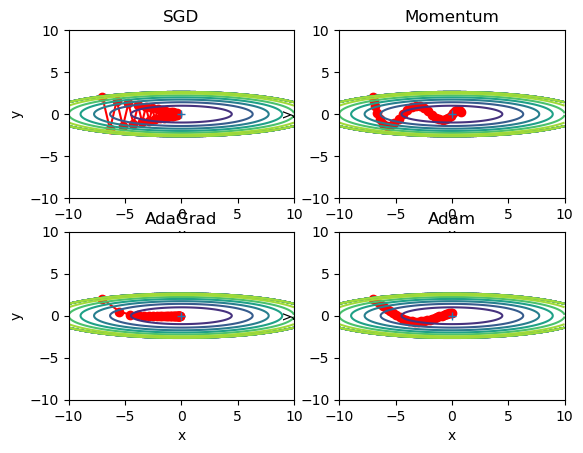

In [21]:
def f(x, y):
    return x**2 / 20.0 + y**2

# 미분 값
def df(x, y): 
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

- SGD에 비해서 모멘텀이 비교적 안정적인 모습을 보임 
- AdaGrad는 기존에 기울기 값이 큰, y방향이 적게 적용되는 모습을 보임
- Adam은 모멘텀의 영향으로 Adagrad보다 y 방향 움직임이 있는 것을 확인 가능

### 6.1.8 MNIST 활용하여 갱신 방법 비교

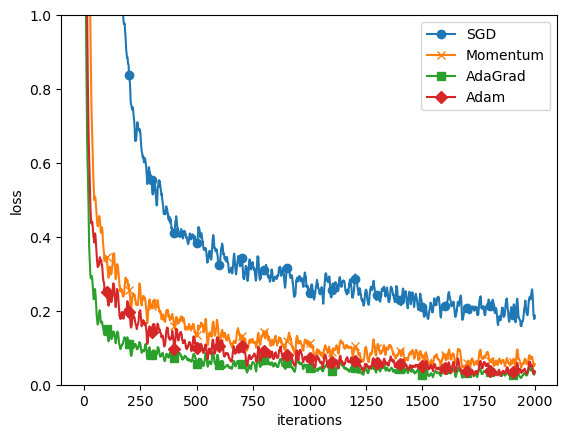

In [23]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# data load
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# optimizers
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 훈련
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
#     if i % 100 == 0:
#         print( "===========" + "iteration:" + str(i) + "===========")
#         for key in optimizers.keys():
#             loss = networks[key].loss(x_batch, t_batch)
#             print(key + ":" + str(loss))


# 시각화
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

AdaGrad, Adam, Momentum, SGD 순으로 loss가 빠르게 줄어듦.

## 6.2 가중치의 초기값 설정 

- 가중치 초기값이 모두 0이면, 오차역전파에 의한 매개변수 갱신이 안됨. (모두 똑같이 갱신되어 버림)

### 6.2.2 가중치 초기값에 따른 은닉층 출력값(활성화값) 변화

#### 가중치 표준편차 1로 초기화

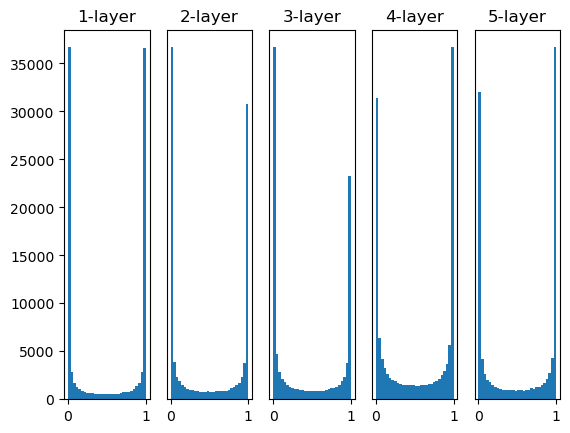

In [32]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1,000개의 무작위 데이터 생성 (0, 1 정규부포를 따르는)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1 # 표준편차 1인 가중치 초기화
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

활성화 값이 0과 1 사이에 치우쳐 있는데, sigmoid 경우 0과 1이면 gradient_vanishing 문제가 발생할 수 있음

#### 가중치 0.01로 초기화

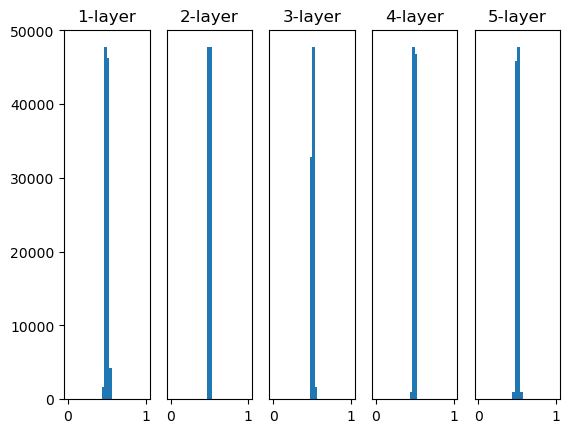

In [33]:
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 0.01 # 표준편차 0.01인 가중치 초기화
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

gradient vanishing 문제는 해결될 수 있으나, 0.5 부근에 집중되어 뉴런의 표현력이 떨어짐..

#### Xavier 초기값

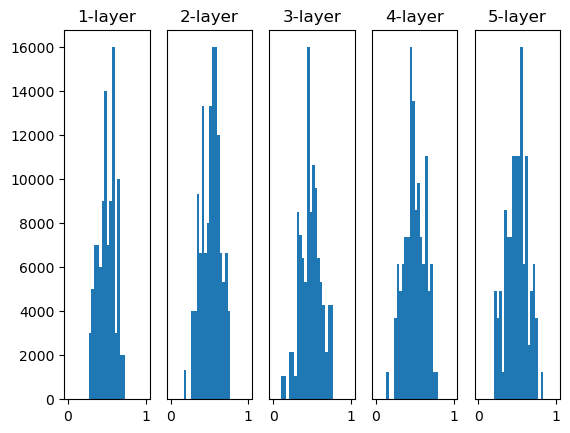

In [34]:
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # 표준편차 0.01인 가중치 초기화
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

앞 계층의 노드가 n개라면, 제곱근의 역수 만큼의 표준분포를 가진 값으로 가중치를 초기화(활성화값을 광범위하게 분포시키기 위해서 활용)  
앞 층의 노드가 많을수록 가중치의 범위가 좁게 형성됨.  
`Xavier 초기값`은 활성화함수가 선형인 경우(sigmoid, tanh)에 좋음. 따라서 ReLU와 같이 비선형이면 다른 초깃값 활용이 좋음.  

** 활성화함수가 선형이라는 말은 y축을 중심으로 대칭

### 6.2.3 ReLU 사용시 가중치 초기값

#### He 초기값

xavier가 sqrt(1/n)이었다면, He는 sqrt(2/n)을 씀.  
음수의 영역에서는 어차피 ReLU는 0이라서, 최대한 넓게 분포시키려 그런듯

In [35]:
def ReLU(x):
    return np.maximum(0, x)
    
input_data = np.random.randn(1000, 100) 
node_num = 100  
hidden_layer_size = 5  
activations_std = {}  
activations_xavier = {}  
activations_he = {}  

x1 = input_data
x2 = input_data
x3 = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x1 = activations_std[i-1]
        x2 = activations_xavier[i-1]
        x3 = activations_he[i-1]

    # 초깃값 설정
    w1 = np.random.randn(node_num, node_num) * 0.01 # 표준편차 기준
    w2 = np.random.randn(node_num, node_num) / np.sqrt(node_num) # xavier
    w3 = np.random.randn(node_num, node_num) / np.sqrt(node_num) * np.sqrt(2) # he
    
    a1 = np.dot(x1, w1)
    a2 = np.dot(x2, w2)
    a3 = np.dot(x3, w3)

    # activation_function
    z1 = ReLU(a1)
    z2 = ReLU(a2)
    z3 = ReLU(a3)

    activations_std[i] = z1
    activations_xavier[i] = z2
    activations_he[i] = z3

표준편차 기준

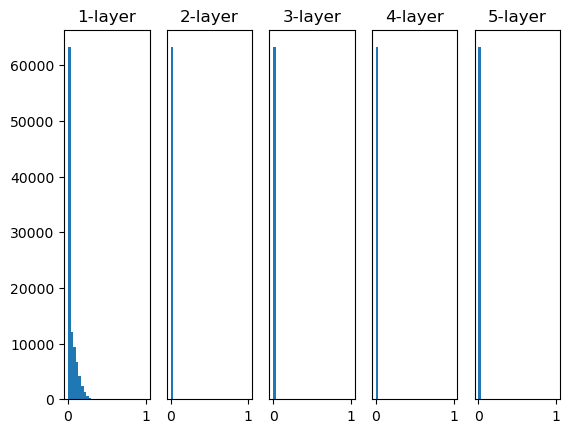

In [37]:
for i, a in activations_std.items():
    plt.subplot(1, len(activations_std), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavier

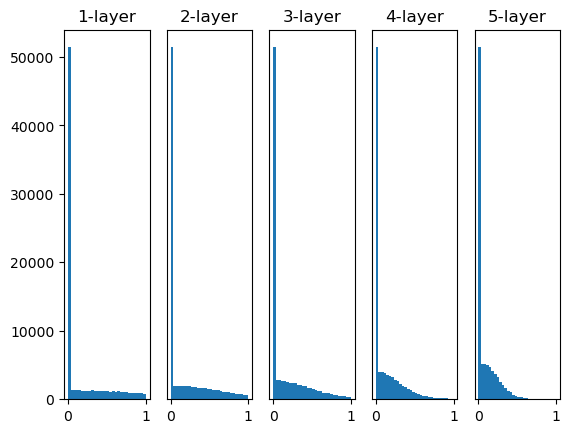

In [38]:
for i, a in activations_xavier.items():
    plt.subplot(1, len(activations_xavier), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

He

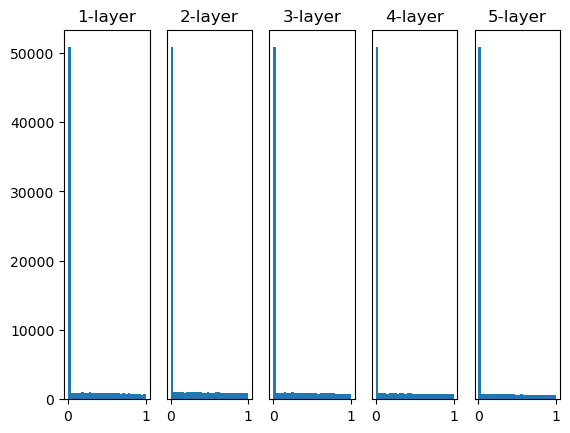

In [39]:
for i, a in activations_he.items():
    plt.subplot(1, len(activations_xavier), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 표준분포 기준은 값이 너무 작게 나타남
- Xavier는 층이 깊어질수록 치우침이 커짐 -> gradient vanishing
- He는 비교적 균등하게 값이 나타남

따라서 ReLU면 He, sigmoid나 tanh면 Xavier

### 6.2.4 MNIST에 가중치 초기화 적용

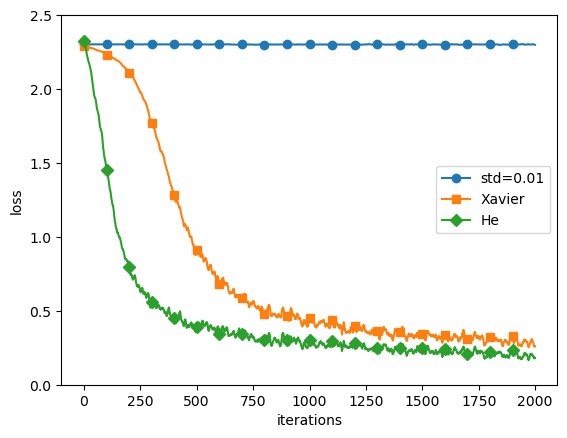

In [40]:
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# data load 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 훈련
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
# 시각화
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

std는 활성화 값이 너무 작게 분포해서 학습이 되지 않음. (역전파 가중치가 0으로 수렴)

## 6.3 배치 정규화

배치 정규화(Batch Normalization)은 각 층의 활성화를 적당히 분포하도록 조정  
배치 정규화의 강점은 다음과 같다.  
- 학습 속도 개선
- 초깃값에 크게 의존하지 않음
- 오버피팅을 억제 (드롭아웃의 필요성 감소)  

배치 정규화는 미니배치 데이터 분포의 평균이 0, 분산이 1이 되도록 정규화 진행

## 6.4 학습 기법

### 6.4.1 오버피팅

In [7]:
# 오버피팅으로 학습.(데이터 적고, 모델 복잡하게 해서)

from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

# data load 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# overfitting을 위해서 적은 데이터를 통한 학습 
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)
epoch_cnt = 0

for i in range(100000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

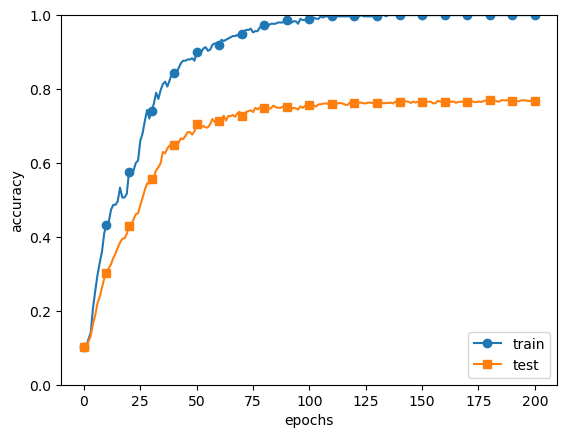

In [8]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train 정확도는 매우 높지만, test는 낮음

### 6.4.2 가중치 감소

학습 과정에서 큰 가중치에 대해 큰 패널티를 부과하여 오버피팅을 억제  
예를 들어 L2 norm을 손실 함수에 더해서, 가중치가 커지는 것을 방지(L1, L무한대도 있음)

In [9]:
# weight decay 실행

# data load 
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# overfitting을 위해서 적은 데이터를 통한 학습 
x_train = x_train[:300]
t_train = t_train[:300]

# 가중치 감소의 람다값을 0.1로 지정
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, \
                       weight_decay_lambda=0.1)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)
epoch_cnt = 0

for i in range(100000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

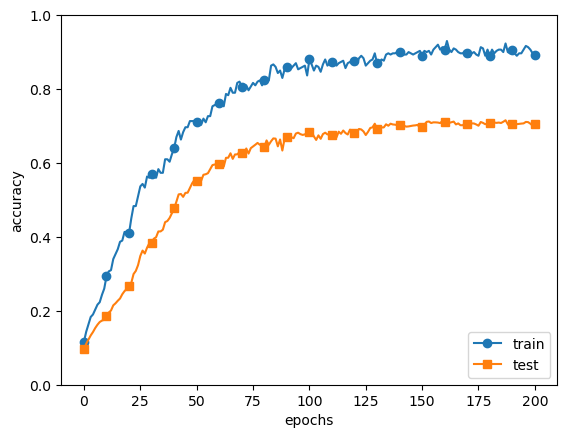

In [10]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

오버피팅을 일부 방지하였음

### 6.4.3 Dropout

훈련과정에서 일부 뉴런을 스킵하며, 신호를 전달.  
시험때는 모든 뉴런을 활용하고, 각 뉴런의 훈련 때 삭제 안 한 비율을 곱하여 출력

In [11]:
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # x와 같은 형상 중 dropout보다 높은 애만 True
            return x * self.mask
        else:
            return x * (1. - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask # ReLU와 유사함

In [14]:
from common.multi_layer_net_extend import MultiLayerNetExtend

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.15

# 가중치 감소의 람다값을 0.1로 지정
network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                       use_dropout=use_dropout, dropout_ration=dropout_ratio)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)
epoch_cnt = 0

for i in range(100000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

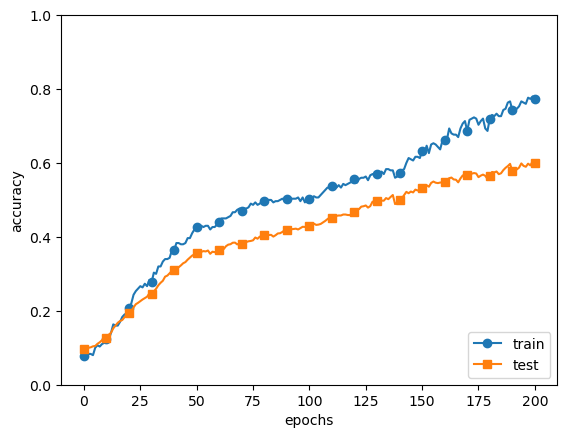

In [15]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

훈련과 테스트 데이터의 차이가 줄어듦.  
책과 다르게 구현된 이유는 randn 같은 랜덤성 초기화 변수 때문임.

## 6.5 하이퍼파라미터 값 찾기

- 검증 데이터 셋을 통해서 하이퍼파라미터 성능 확인
- 신경망 하이퍼파라미터 최적화에서는 그리드서치와 같은 규칙적 탐색보다는 무작위 샘플링 탐색이 더 결과가 좋음(파라미터 별 영향력이 달라서)
- 학습 에폭을 작게해서 많은 평가 후, 하이퍼파라미터 범위를 좁혀나감(학습 시간 때문에) 

In [18]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # 

    val_acc_list, train_acc_list = __train(lr, weight_decay)
#     print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

In [19]:
cnt = 0 
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)
    cnt += 1 
    if cnt > 4:
        break

Best-601(val acc:0.78) | lr:0.007030140862318107, weight decay:3.30542373211257e-08
Best-601(val acc:0.77) | lr:0.008707312417894852, weight decay:2.9133219389139196e-06
Best-601(val acc:0.77) | lr:0.008122520757972285, weight decay:5.492605344021526e-06
Best-601(val acc:0.71) | lr:0.005390484847323456, weight decay:4.433446507487411e-08
Best-601(val acc:0.71) | lr:0.006822837668134502, weight decay:8.25601000551269e-06


100회의 무작위 탐색 후, 높은 val acc를 보이는 5개의 결과 print